### refer : https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, )
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_dir='../../')

In [3]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
PATH, train_dir, validation_dir

('../../datasets/cats_and_dogs_filtered',
 '../../datasets/cats_and_dogs_filtered/train',
 '../../datasets/cats_and_dogs_filtered/validation')

In [4]:
# train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
# train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
# validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
# validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# num_cats_tr = len(os.listdir(train_cats_dir))
# num_dogs_tr = len(os.listdir(train_dogs_dir))

# num_cats_val = len(os.listdir(validation_cats_dir))
# num_dogs_val = len(os.listdir(validation_dogs_dir))

# total_train = num_cats_tr + num_dogs_tr
# total_val = num_cats_val + num_dogs_val
batch_size = 128
IMG_HEIGHT = 160
IMG_WIDTH = 160
# WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest') # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
sample_training_images, _ = next(train_data_gen)
sample_training_images.shape

(128, 160, 160, 3)

In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH ,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

Metal device set to: Apple M1


2022-01-05 17:23:51.565912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-05 17:23:51.565994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [9]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
# len(model.trainable_variables)
# model.summary()

In [12]:
initial_epochs = 20

hist = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

2022-01-05 17:23:52.674223: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-01-05 17:23:53.266867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.7978 - accuracy: 0.5305

2022-01-05 17:24:00.907771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 11s 620ms/step - loss: 0.7978 - accuracy: 0.5305 - val_loss: 0.7230 - val_accuracy: 0.5370
Epoch 2/20
16/16 [==============================] - 10s 625ms/step - loss: 0.7193 - accuracy: 0.5770 - val_loss: 0.6416 - val_accuracy: 0.5860
Epoch 3/20
16/16 [==============================] - 10s 638ms/step - loss: 0.6618 - accuracy: 0.6095 - val_loss: 0.5711 - val_accuracy: 0.6340
Epoch 4/20
16/16 [==============================] - 10s 620ms/step - loss: 0.6114 - accuracy: 0.6520 - val_loss: 0.5165 - val_accuracy: 0.6720
Epoch 5/20
16/16 [==============================] - 11s 659ms/step - loss: 0.5582 - accuracy: 0.6870 - val_loss: 0.4735 - val_accuracy: 0.6990
Epoch 6/20
16/16 [==============================] - 10s 649ms/step - loss: 0.5313 - accuracy: 0.7030 - val_loss: 0.4384 - val_accuracy: 0.7290
Epoch 7/20
16/16 [==============================] - 10s 622ms/step - loss: 0.4840 - accuracy: 0.7470 - val_loss: 0.4082 - val_accuracy: 0.7510
Epoch 8/20

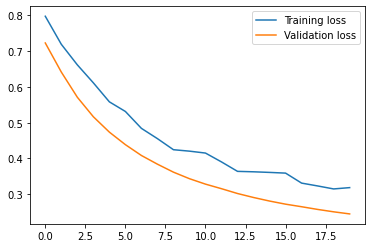

In [13]:
import matplotlib.pyplot as plt
plt.plot(hist.epoch, hist.history['loss'], label='Training loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

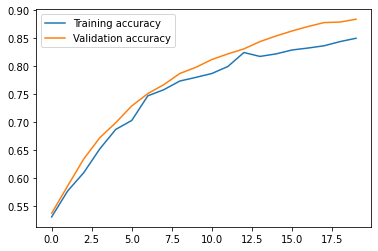

In [14]:
plt.plot(hist.epoch, hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

### fineTuning

In [17]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 20

hist = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/20


2022-01-05 17:28:39.794829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.5415

2022-01-05 17:28:50.199780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 14s 685ms/step - loss: 0.7803 - accuracy: 0.5415 - val_loss: 0.6385 - val_accuracy: 0.5900
Epoch 2/20
16/16 [==============================] - 11s 673ms/step - loss: 0.6191 - accuracy: 0.6465 - val_loss: 0.4987 - val_accuracy: 0.6750
Epoch 3/20
16/16 [==============================] - 11s 646ms/step - loss: 0.4949 - accuracy: 0.7160 - val_loss: 0.4116 - val_accuracy: 0.7430
Epoch 4/20
16/16 [==============================] - 11s 655ms/step - loss: 0.4271 - accuracy: 0.7785 - val_loss: 0.3534 - val_accuracy: 0.8030
Epoch 5/20
16/16 [==============================] - 10s 641ms/step - loss: 0.3784 - accuracy: 0.8045 - val_loss: 0.3082 - val_accuracy: 0.8450
Epoch 6/20
16/16 [==============================] - 10s 628ms/step - loss: 0.3392 - accuracy: 0.8375 - val_loss: 0.2706 - val_accuracy: 0.8730
Epoch 7/20
16/16 [==============================] - 10s 635ms/step - loss: 0.3145 - accuracy: 0.8575 - val_loss: 0.2399 - val_accuracy: 0.8910
Epoch 8/20

In [19]:
model.save('./model_finetuning_MobileNetV2.h5')

/Users/sanghunoh/miniforge3/envs/ml_p3.9_tf2.7/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
